# **Case Study 1 - COVID-19 Prediction Based on Lung X-rays**

The objective of this notebook is to build a model to predict if a person has Covid-19 or other infections or no lung infection from the lung x-rays.

The dataset contains lungs x-rays classified by three labels:
- COVID-19: from patients suffering from COVID-19.
- Non-COVID: from patients suffering from other diseases.
- Healthy: from patients classified as healthy.

## Data Preprocessing

In [1]:
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import normalize, StandardScaler
import cv2
import matplotlib.pyplot as plt
from skimage import exposure

In [2]:
# Accesing dataset folder
dataset_folder = '/Users/marcus/Library/CloudStorage/OneDrive-Personal/Documentos/Loyalist_College/AISC2007/Assignment3/Val'

#classes in dataset
classes = ['COVID-19', 'Non-COVID', 'Normal']

In [3]:
# Initializing empty lists for images, masks, and labels
images = []
masks = []
labels = []

In [4]:
#setting image size
target_size = (224, 224)

# Looping through each class folder
for class_name in classes:
    class_folder = os.path.join(dataset_folder, class_name, 'images')
    mask_folder = os.path.join(dataset_folder, class_name, 'lung masks')
    
    for filename in os.listdir(class_folder):
        img_path = os.path.join(class_folder, filename)
        mask_path = os.path.join(mask_folder, filename)
        
        # Load and resize the image
        img = image.load_img(img_path, target_size=target_size, color_mode='grayscale')
        img_array = image.img_to_array(img)
        
        # Load and resize the mask
        mask = image.load_img(mask_path, target_size=target_size, color_mode='grayscale')
        mask_array = image.img_to_array(mask)
        
        # Appending to the lists
        images.append(img_array)
        masks.append(mask_array)
        labels.append(classes.index(class_name))

# Converting lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)
labels = to_categorical(labels, num_classes=len(classes))

In [5]:
# Printing the size & shape of images and masks and labels
print(" Image Size:", images.shape)
print(" Mask Size:", masks.shape)
print(" Label Size:", labels.shape)

 Image Size: (5417, 224, 224, 1)
 Mask Size: (5417, 224, 224, 1)
 Label Size: (5417, 3)


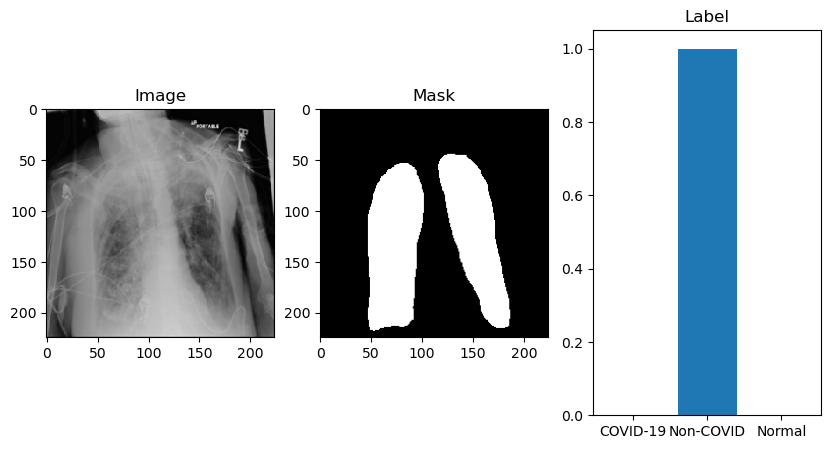

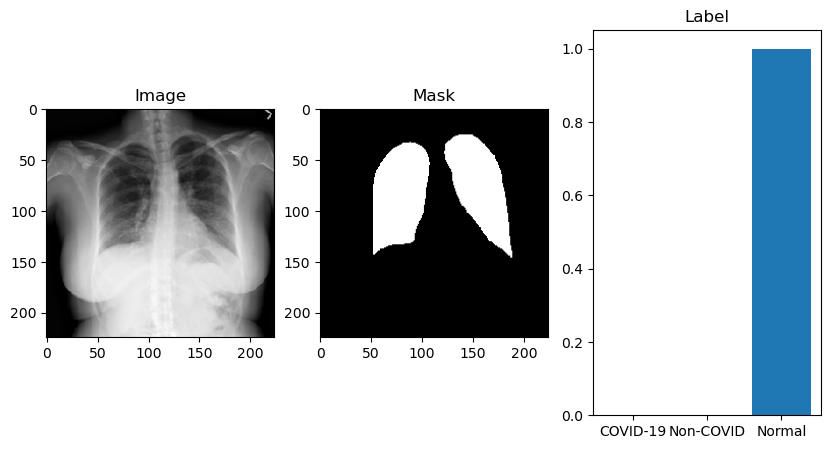

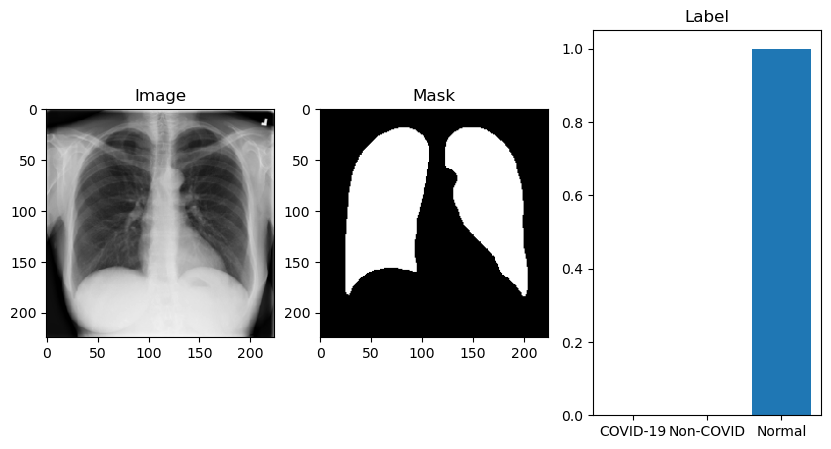

In [6]:
# Choosing a few random indices to display
indices_to_display = np.random.choice(len(images), size=3, replace=False)

for idx in indices_to_display:
    # Display the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[idx].reshape(images[idx].shape[:-1]), cmap='gray')
    plt.title('Image')

    # Display the mask
    plt.subplot(1, 3, 2)
    plt.imshow(masks[idx].reshape(masks[idx].shape[:-1]), cmap='gray')
    plt.title('Mask')

    # Display the label
    plt.subplot(1, 3, 3)
    plt.bar(range(len(classes)), labels[idx])
    plt.xticks(range(len(classes)), classes)
    plt.title('Label')

    plt.show()


In [7]:
# For Images
min_value_images = np.min(images)
max_value_images = np.max(images)

# For Masks
min_value_masks = np.min(masks)
max_value_masks = np.max(masks)


print("Images values range: {} to {}".format(min_value_images, max_value_images))
print("Masks values range: {} to {}".format(min_value_masks, max_value_masks))

Images values range: 0.0 to 255.0
Masks values range: 0.0 to 255.0


In [8]:
# Combining images, masks, and labels
combined_data = list(zip(images, masks, labels))

from sklearn.model_selection import train_test_split

# Spliting the combined data into training, validation, and test sets
train_data, temp_data = train_test_split(combined_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Unpacking the data into separate lists
X_train, masks_train, y_train = zip(*train_data)
X_val, masks_val, y_val = zip(*val_data)
X_test, masks_test, y_test = zip(*test_data)

# Converting lists to NumPy arrays
X_train = np.array(X_train)
masks_train = np.array(masks_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
masks_val = np.array(masks_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
masks_test = np.array(masks_test)
y_test = np.array(y_test)

# Printing the size of each set
print("X_train size:", X_train.shape)
print("masks_train size:", masks_train.shape)
print("y_train size:", y_train.shape)

print("X_val size:", X_val.shape)
print("masks_val size:", masks_val.shape)
print("y_val size:", y_val.shape)

print("X_test size:", X_test.shape)
print("masks_test size:", masks_test.shape)
print("y_test size:", y_test.shape)

X_train size: (4333, 224, 224, 1)
masks_train size: (4333, 224, 224, 1)
y_train size: (4333, 3)
X_val size: (542, 224, 224, 1)
masks_val size: (542, 224, 224, 1)
y_val size: (542, 3)
X_test size: (542, 224, 224, 1)
masks_test size: (542, 224, 224, 1)
y_test size: (542, 3)


In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.1,  
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Iterating over the training data and perform data augmentation
augmented_images_train = []
augmented_masks_train = []

for idx in range(len(X_train)):
    img = X_train[idx]
    mask = masks_train[idx]

    # Reshaping the image and mask to (224, 224, 1) for compatibility with the generator
    img = img.reshape((1,) + img.shape)
    mask = mask.reshape((1,) + mask.shape)

    # Generating augmented images and masks
    augmented_img_gen = datagen.flow(img, batch_size=1, seed=42)
    augmented_mask_gen = datagen.flow(mask, batch_size=1, seed=42)

    augmented_img = augmented_img_gen.next()[0]
    augmented_mask = augmented_mask_gen.next()[0]

    augmented_images_train.append(augmented_img)
    augmented_masks_train.append(augmented_mask)

# Converting augmented lists to NumPy arrays
augmented_images_train = np.array(augmented_images_train)
augmented_masks_train = np.array(augmented_masks_train)

In [10]:
# Concatenating the original and augmented images and masks for training set
X_train_combined = np.concatenate((X_train, augmented_images_train), axis=0)
masks_train_combined = np.concatenate((masks_train, augmented_masks_train), axis=0)
y_train_combined = np.concatenate((y_train, y_train[:len(augmented_images_train)]), axis=0)


# Printing the size of the combined training set
print("X_train_combined size:", X_train_combined.shape)
print("combined_masks_train size:", masks_train_combined.shape)
print("y_train_combined size:", y_train_combined.shape)

X_train_combined size: (8666, 224, 224, 1)
combined_masks_train size: (8666, 224, 224, 1)
y_train_combined size: (8666, 3)


In [11]:
from sklearn.preprocessing import normalize

# Normalizing and Standardizing the data
X_train_normalized = normalize(X_train_combined.reshape(X_train_combined.shape[0], -1), axis=1).reshape(X_train_combined.shape)
masks_train_normalized = normalize(masks_train_combined.reshape(masks_train_combined.shape[0], -1), axis=1).reshape(masks_train_combined.shape)

X_val_normalized = normalize(X_val.reshape(X_val.shape[0], -1), axis=1).reshape(X_val.shape)
masks_val_normalized = normalize(masks_val.reshape(masks_val.shape[0], -1), axis=1).reshape(masks_val.shape)

X_test_normalized = normalize(X_test.reshape(X_test.shape[0], -1), axis=1).reshape(X_test.shape)
masks_test_normalized = normalize(masks_test.reshape(masks_test.shape[0], -1), axis=1).reshape(masks_test.shape)

## Image Enhancing

In [12]:
# Applying histogram equalization
def apply_histogram_equalization(image):
    equalized_img = exposure.equalize_hist(image)
    return equalized_img

# Applying histogram equalization to all images
images_equalized = [apply_histogram_equalization(img) for img in X_train_combined]

# Converting to NumPy array
images_equalized = np.array(images_equalized)


C:\Users\edulo\anaconda3\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [13]:
# Applying threshold
def apply_intensity_threshold(image, threshold=128):
    _, thresh_img = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return thresh_img

# Applying intensity threshold to all images
images_thresholded = [apply_intensity_threshold(img) for img in X_train_combined]

# Converting to NumPy array
images_thresholded = np.array(images_thresholded)

In [14]:
# Applying Gaussian blur
def apply_gaussian_blur(image, sigma=1):
    blurred_img = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)
    return blurred_img

# Applying Gaussian blur to all images
images_blurred = [apply_gaussian_blur(img) for img in X_train_combined]

# Converting to NumPy array
images_blurred = np.array(images_blurred)

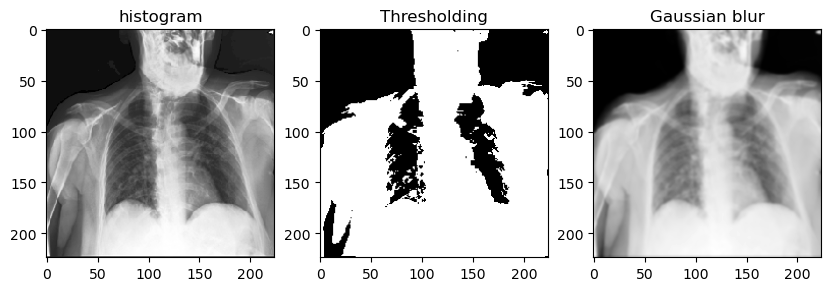

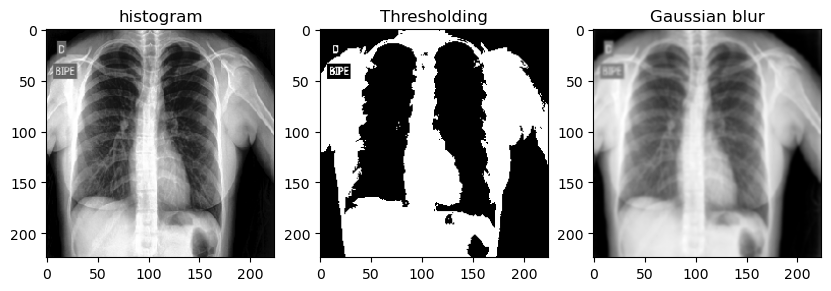

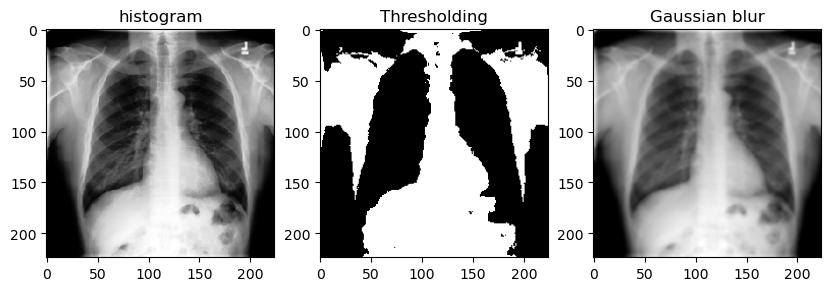

In [15]:
# Choosing a few random indices to display
indices_to_display = np.random.choice(len(images), size=3, replace=False)

for idx in indices_to_display:
    # Display the histogram image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images_equalized[idx].reshape( X_train_combined[idx].shape[:-1]), cmap='gray')
    plt.title('histogram')

    # Display the thresholding image
    plt.subplot(1, 3, 2)
    plt.imshow(images_thresholded[idx].reshape(X_train_combined[idx].shape[:-1]), cmap='gray')
    plt.title('Thresholding')
    
    # Display the blur image
    plt.subplot(1, 3, 3)
    plt.imshow(images_blurred[idx].reshape(X_train_combined[idx].shape[:-1]), cmap='gray')
    plt.title('Gaussian blur')

plt.show()
 

## **CNN Modeling - Merged Images and Masks Approach**

For this approach, we will combine the images and the masks side-by-side and use it to train a CNN model.

Initially, we will use the original images, without any equalization.

In [16]:
# combining the train datasets
X_train_merged = np.concatenate((X_train_combined, masks_train_combined), axis=2)
# X_train_merged = np.concatenate((X_train_normalized, masks_train_normalized), axis=2)
X_train_merged.shape

(8666, 224, 448, 1)

In [17]:
# combining the val datasets
X_val_merged = np.concatenate((X_val, masks_val), axis=2)
# X_val_merged = np.concatenate((X_val_normalized, masks_val_normalized), axis=2)
X_val_merged.shape

(542, 224, 448, 1)

In [65]:
# combining the test datasets
X_test_merged = np.concatenate((X_test, masks_test), axis=2)
X_test_merged.shape

(542, 224, 448, 1)

Text(0.5, 1.0, 'Merged Image')

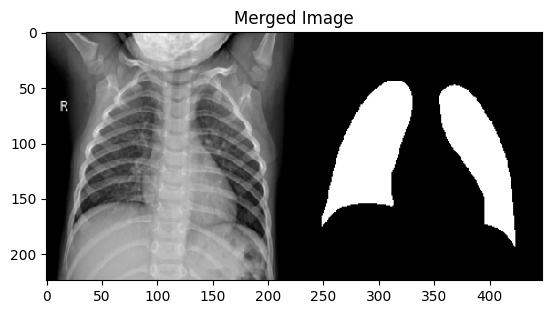

In [18]:
plt.imshow(X_train_merged[0].reshape( X_train_merged[0].shape[:-1]), cmap='gray')
plt.title('Merged Image')

In [19]:
# importing the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
import math
import seaborn as sns

In [20]:
# function to plot the loss and accuracy of the NN
def plot_history(history):
    # accessing the training and validation accuracy values
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    x = [i for i in range (1, len(train_accuracy) + 1)]

    # creating two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # plotting the lines on the first subplot
    ax1.plot(x, train_loss, label='train_loss')
    ax1.plot(x, val_loss, label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # plotting the lines on the second subplot
    ax2.plot(x, train_accuracy, label='train_accuracy')
    ax2.plot(x, val_accuracy, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [66]:
# function that calculates performance metrics
def performance(model, X_val_merged, y_val, classes):
    # geting model predictions
    y_pred_prob = model.predict(X_val_merged)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # converting the y_val (one-hot encoded) to class labels
    y_val_labels = np.argmax(y_val, axis=1)

    accuracy = accuracy_score(y_val_labels, y_pred)
    print(f'Accuracy: {accuracy}')

    class_report = classification_report(y_val_labels, y_pred, target_names=classes)
    print('\nClassification Report:\n', class_report)

    # One-hot encode y_val_labels for AUC calculation
    y_val_one_hot = to_categorical(y_val_labels)

    # Calculate AUC for each class and take the average
    auc = roc_auc_score(y_val_one_hot, y_pred_prob, multi_class='ovr')
    print(f'Average AUC: {auc}')
    print()
    
    conf_matrix = confusion_matrix(y_val_labels, y_pred)
    print('Confusion Matrix:\n', conf_matrix)
    print()

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


### Base model

In [22]:
# building base model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 448, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

2024-02-16 11:11:56.323036: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-16 11:11:56.323251: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-16 11:11:56.323258: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-16 11:11:56.323965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-16 11:11:56.324796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 446, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 223, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 221, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 110, 128)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 760320)            0         
                                                                 
 dense (Dense)               (None, 32)                2

In [23]:
# compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# configuring early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [25]:
# training the model
history = model.fit(X_train_merged, y_train_combined, epochs=15, batch_size=32, validation_data=(X_val_merged, y_val), callbacks=[early_stopping])

Epoch 1/15


2024-02-16 11:12:02.206217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 54s 193ms/step - loss: 171.1220 - accuracy: 0.4575 - val_loss: 2.6262 - val_accuracy: 0.5221
Epoch 2/15
271/271 [==============================] - 57s 210ms/step - loss: 1.3690 - accuracy: 0.6272 - val_loss: 1.9867 - val_accuracy: 0.5627
Epoch 3/15
271/271 [==============================] - 56s 208ms/step - loss: 0.5699 - accuracy: 0.7930 - val_loss: 1.9769 - val_accuracy: 0.5867
Epoch 4/15
271/271 [==============================] - 57s 209ms/step - loss: 0.2997 - accuracy: 0.8859 - val_loss: 2.1902 - val_accuracy: 0.5978
Epoch 5/15
271/271 [==============================] - 57s 212ms/step - loss: 0.1602 - accuracy: 0.9423 - val_loss: 2.4474 - val_accuracy: 0.6236
Epoch 6/15
271/271 [==============================] - 57s 210ms/step - loss: 0.0770 - accuracy: 0.9775 - val_loss: 2.7847 - val_accuracy: 0.6384
Epoch 7/15
271/271 [==============================] - 57s 210ms/step - loss: 0.0790 - accuracy: 0.9714 - val_loss: 3.1089 - val_accuracy: 0

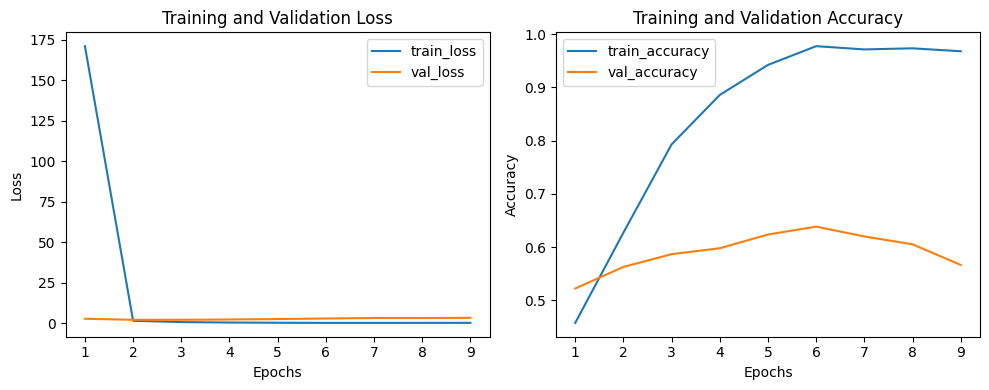

In [26]:
plot_history(history)

17/17 [==============================] - 1s 47ms/step
Accuracy: 0.6383763837638377

Classification Report:
               precision    recall  f1-score   support

    COVID-19       0.70      0.61      0.65       200
   Non-COVID       0.61      0.60      0.61       153
      Normal       0.61      0.70      0.65       189

    accuracy                           0.64       542
   macro avg       0.64      0.64      0.64       542
weighted avg       0.64      0.64      0.64       542

Average AUC: 0.8004134059777054

Confusion Matrix:
 [[122  27  51]
 [ 27  92  34]
 [ 26  31 132]]



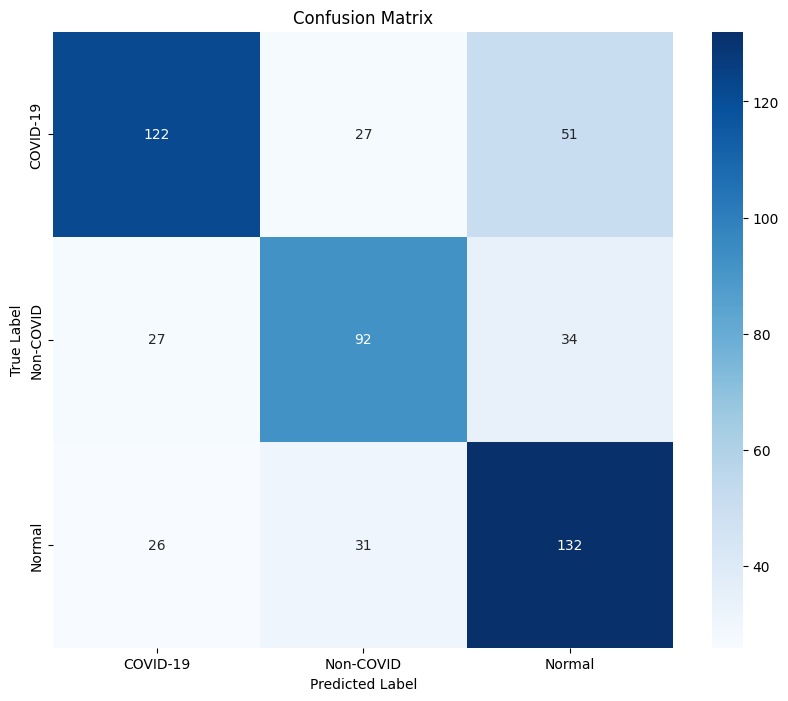

In [27]:
performance(model, X_val_merged, y_val, classes)

Base model performance evaluation (val dataset)
- This model is composed of two convolutional and two dense layers. It overfits and can only get a accuracy of 63.87%.
- COVID-19 Class has a relatively higher precision (0.70) than recall (0.61), suggesting that the model is better at identifying positive cases, but it misses a significant number of actual positive cases.
- Non-COVID Class has a balanced precision (0.61) and recall (0.60), suggesting that the model's performance in identifying this class is balanced.
- Normal Class has a higher recall (0.70) compared to precision (0.61), indicating that the model is better at capturing the the Normal cases, but it also incorrectly labels other classes as Normal.
- Average AUC is ok at minimum. It can distinguish the classes, but not precisely.
- Confusion Matrix
    - The model has a tendency to mistake COVID-19 with Normal cases.

The next step is to improve the architecture and tune the model to improve the accuracy and prevent overfitting.

### Tuned model

We will apply Learning Rate Scheduler to adjust the learning rate at later stages of training and improve the accuracy.

Reference: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1?gi=ae179652b2a8

In [51]:
# function for step decay schedule.
def step_decay(epoch):
    initial_lr = 0.01  # starting learning rate
    drop = 0.5  # factor by which to drop the LR
    epochs_drop = 8.0  # drop the LR every 8 epochs
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)

The model below is the final one after many attempts to improve and tune the architecture in order to prevent overfitting.

The convolutional and pooling layers were used to reduce the number of features while still capturing the most important details. Dropout was added for regularization.

In [52]:
# configuring early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

In [53]:
# tuned model
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 448, 1)))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(3, activation='softmax'))

model2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 446, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 223, 32)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_16 (Ba  (None, 111, 223, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 221, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 54, 110, 64)       0         
 ng2D)                                                           
                                                      

In [54]:
# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
# Train the model
history2 = model2.fit(X_train_merged, y_train_combined, epochs=50, batch_size=32, validation_data=(X_val_merged, y_val), callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
271/271 [==============================] - 64s 232ms/step - loss: 3.8946 - accuracy: 0.5419 - val_loss: 1.8521 - val_accuracy: 0.5683 - lr: 0.0100
Epoch 2/50
271/271 [==============================] - 62s 229ms/step - loss: 0.9788 - accuracy: 0.6408 - val_loss: 0.7274 - val_accuracy: 0.6863 - lr: 0.0100
Epoch 3/50
271/271 [==============================] - 62s 229ms/step - loss: 0.7266 - accuracy: 0.6933 - val_loss: 0.6897 - val_accuracy: 0.7030 - lr: 0.0100
Epoch 4/50
271/271 [==============================] - 62s 229ms/step - loss: 0.6799 - accuracy: 0.7141 - val_loss: 0.6991 - val_accuracy: 0.6919 - lr: 0.0100
Epoch 5/50
271/271 [==============================] - 62s 230ms/step - loss: 0.6655 - accuracy: 0.7205 - val_loss: 0.6568 - val_accuracy: 0.7362 - lr: 0.0100
Epoch 6/50
271/271 [==============================] - 62s 228ms/step - loss: 0.6367 - accuracy: 0.7278 - val_loss: 0.6213 - val_accuracy: 0.7509 - lr: 0.0100
Epoch 7/50
271/271 [==============================] 

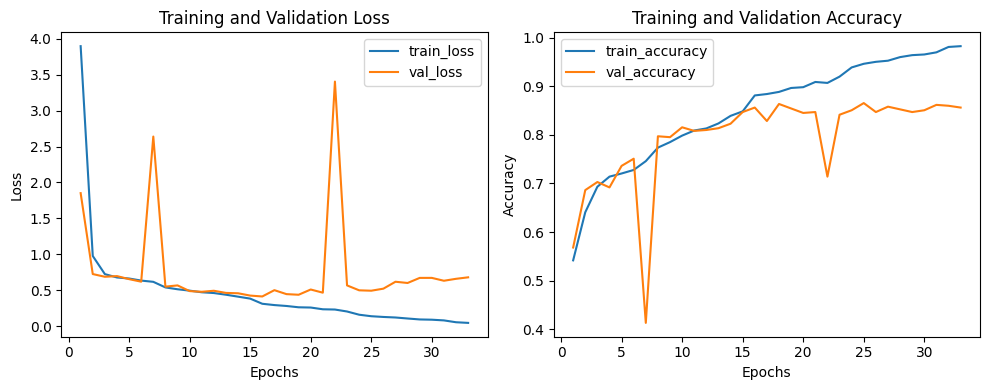

In [56]:
plot_history(history2)

17/17 [==============================] - 1s 81ms/step
Accuracy: 0.8560885608856088

Classification Report:
               precision    recall  f1-score   support

    COVID-19       0.92      0.91      0.92       206
   Non-COVID       0.81      0.85      0.83       175
      Normal       0.83      0.79      0.81       161

    accuracy                           0.86       542
   macro avg       0.85      0.85      0.85       542
weighted avg       0.86      0.86      0.86       542

Average AUC: 0.9636594580037627

Confusion Matrix:
 [[188   8  10]
 [ 10 149  16]
 [  6  28 127]]



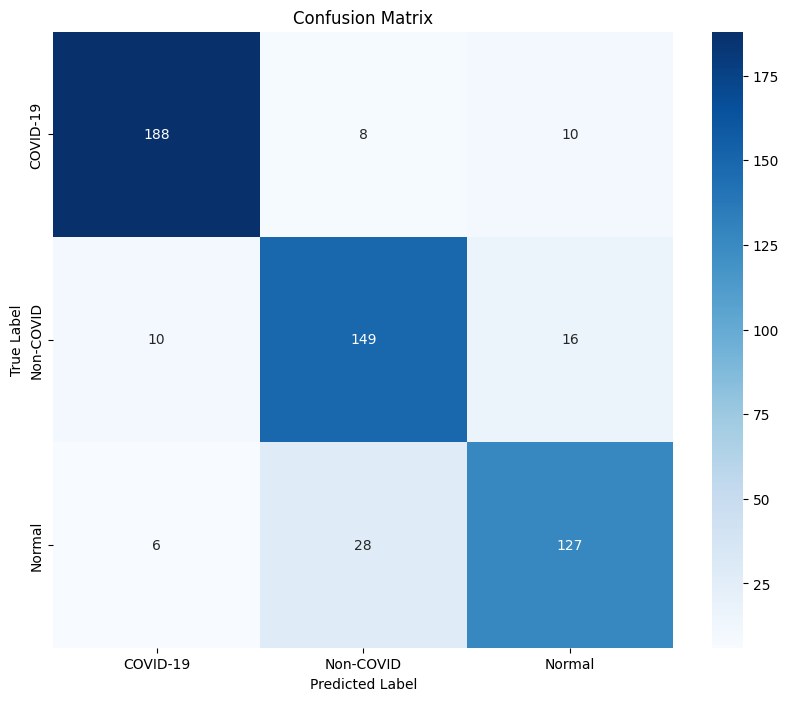

In [68]:
performance(model2, X_test_merged, y_test, classes)

Tuned model performance evaluation (test dataset)
- The accuracy improved substantially, up to 85.6%
- COVID-19 has a high precision and recall, indicating that the model is great in correctly identifying these cases.
- Non-COVID has a higher recall than precision, suggesting the model is relatively better at identifying Non-COVID cases, while also incorrectly defining other cases as Non-COVID.
- Normal shows a good precision and a moderate recall, but it has a slight bias when identifying false positives (predicting Normal when it's not).
- The AUC of 0.96 indicates that the model is great at classifying the images.
- Confusion Matrix
    - The number of true positives is high, indicating strong performance.
    - Normal cases are sometimes classified as Non-COVID.

# Cross-validation

Reference: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

In [62]:
# configuring early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

In [64]:
from sklearn.model_selection import KFold
num_folds = 5

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((X_train_merged, X_val_merged), axis=0)
targets = np.concatenate((y_train_combined, y_val), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, val in kfold.split(inputs, targets):
    # Define the model architecture
    model3 = Sequential()
    model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 448, 1)))
    model3.add(MaxPooling2D((2, 2)))
    model3.add(BatchNormalization())
    model3.add(Conv2D(64, (3, 3), activation='relu'))
    model3.add(MaxPooling2D((2, 2)))
    model3.add(BatchNormalization())
    model3.add(Conv2D(128, (5, 5), activation='relu'))
    model3.add(MaxPooling2D((2, 2)))
    model3.add(BatchNormalization())
    model3.add(Conv2D(32, (5, 5), activation='relu'))
    model3.add(MaxPooling2D((2, 2)))
    model3.add(BatchNormalization())
    model3.add(Flatten())
    model3.add(Dropout(0.25))
    model3.add(Dense(3, activation='softmax'))

    # Compile the model
    model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train the model
    history3 = model3.fit(inputs[train], targets[train], epochs=25, batch_size=50, validation_data=(inputs[val], targets[val]), callbacks=[lr_scheduler, early_stopping])
    
    # Generate generalization metrics
    scores = model3.evaluate(inputs[val], targets[val], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores
print()
print('Score per fold:')
for i in range(0, len(acc_per_fold)):
  print()
  print(f'  Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print()
print('Average scores for all folds:')
print(f'  Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'  Loss: {np.mean(loss_per_fold)}')
print()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
148/148 [==============================] - 63s 407ms/step - loss: 4.6196 - accuracy: 0.5375 - val_loss: 4.1430 - val_accuracy: 0.4767 - lr: 0.0100
Epoch 2/25
148/148 [==============================] - 57s 383ms/step - loss: 1.5804 - accuracy: 0.6101 - val_loss: 0.8926 - val_accuracy: 0.6726 - lr: 0.0100
Epoch 3/25
148/148 [==============================] - 55s 374ms/step - loss: 0.9327 - accuracy: 0.6614 - val_loss: 0.9261 - val_accuracy: 0.6439 - lr: 0.0100
Epoch 4/25
148/148 [==============================] - 56s 378ms/step - loss: 0.7251 - accuracy: 0.7030 - val_loss: 0.6962 - val_accuracy: 0.6938 - lr: 0.0100
Epoch 5/25
148/148 [==============================] - 55s 373ms/step - loss: 0.6619 - accuracy: 0.7247 - val_loss: 0.6336 - val_accuracy: 0.7383 - lr: 0.0100
Epoch 6/25
148/148 [==============================] - 56s 377ms/step - loss: 0.6306 - accuracy: 0.7407 - val_loss

17/17 [==============================] - 1s 81ms/step
Accuracy: 0.8726937269372693

Classification Report:
               precision    recall  f1-score   support

    COVID-19       0.96      0.93      0.95       206
   Non-COVID       0.84      0.83      0.83       175
      Normal       0.80      0.85      0.83       161

    accuracy                           0.87       542
   macro avg       0.87      0.87      0.87       542
weighted avg       0.88      0.87      0.87       542

Average AUC: 0.9648554203751871

Confusion Matrix:
 [[191   7   8]
 [  4 145  26]
 [  3  21 137]]



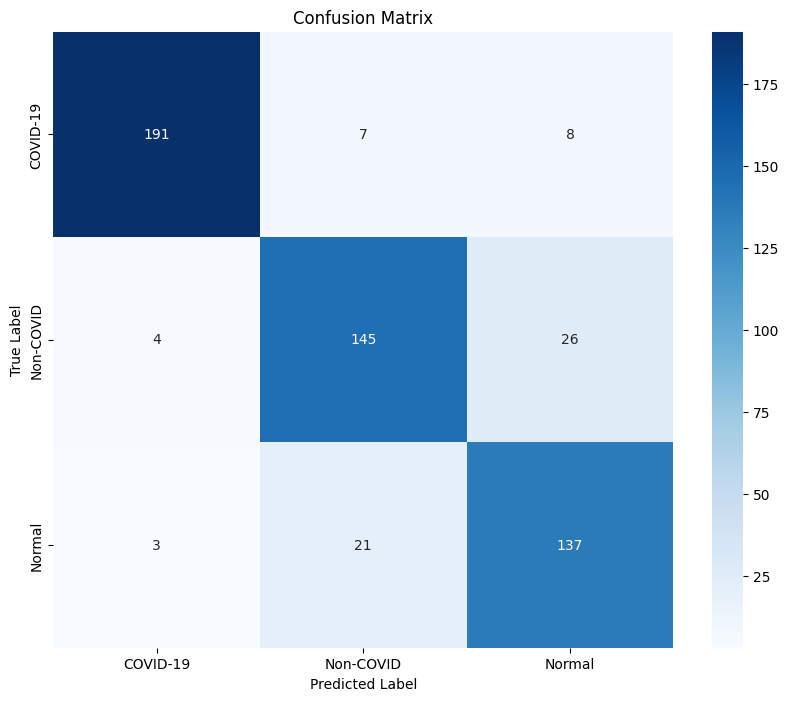

In [69]:
performance(model3, X_test_merged, y_test, classes)

Tuned model trained with cross-validation performance evaluation (test dataset)
- The accuracy improved around 2% compared to the same model trained withou this technique. More epochs could have improved the accuracy even more.
- COVID-19 and Non-COVID's precision and recall are balanced and improved compared to the previous model.
- Normal's precision got worse, while the recall improved significantly.
- The AUC remained similar.
- Confusion Matrix
    - Now Non-COVID cases are sometimes classified as Normal.
    - Normal cases are sometimes classified as Non-COVID.